In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass
from typing import Tuple, Dict, List

%matplotlib inline

In [9]:
data = pd.read_csv('data\stupid_test_data.csv', index_col=0)
data.head()

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
sample_1,1561,1572,1688,1711,1869,1924,2020,2208,2327,2556,...,1323,1328,1312,1339,1362,1347,1382,1401,1409,0
sample_2,1832,1894,2071,2129,2326,2432,2567,2826,3064,3383,...,1455,1463,1451,1480,1510,1504,1560,1579,1589,0
sample_3,1851,1932,2110,2182,2374,2488,2622,2887,3127,3457,...,1472,1478,1457,1495,1526,1525,1569,1598,1605,0
sample_4,1926,2011,2202,2280,2498,2620,2769,3055,3331,3695,...,1516,1521,1503,1542,1571,1563,1624,1651,1661,0
sample_5,1856,1924,2094,2165,2357,2470,2604,2877,3120,3450,...,1472,1478,1459,1499,1525,1524,1569,1600,1605,0


In [10]:
class_dict = {'aurora': 0, 'ettore' : 1}
class_col_name = 'class'

In [11]:
spectral_data = torch.from_numpy(data.iloc[:, :-1].to_numpy().astype("float32")).type(torch.float32)
spectral_data

tensor([[1561., 1572., 1688.,  ..., 1382., 1401., 1409.],
        [1832., 1894., 2071.,  ..., 1560., 1579., 1589.],
        [1851., 1932., 2110.,  ..., 1569., 1598., 1605.],
        ...,
        [1497., 1495., 1602.,  ..., 1339., 1351., 1361.],
        [1557., 1563., 1683.,  ..., 1383., 1402., 1410.],
        [1518., 1514., 1629.,  ..., 1354., 1371., 1375.]])

In [12]:
labels = torch.from_numpy(data[class_col_name].to_numpy().astype(
            "uint8")).type(torch.uint8)
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=torch.uint8)

In [22]:
from torch.utils.data import Dataset
class NIRSpectralData(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, root_dir: str, label_column_name: str, class_dict: dict = None, transform=None) -> None:

        # setup root_dir to .csv file
        self.root_dir = root_dir
        # setup label columns name
        self.label_col_name = label_column_name
        # setup data and labels
        self.df = pd.read_csv(root_dir, index_col=0)
        
        self.data = torch.from_numpy(
            self.df.iloc[:, :-1].to_numpy().astype("float32")).type(torch.float32)
        
        self.labels = torch.from_numpy(self.df[self.label_col_name].to_numpy().astype("uint8")).type(torch.uint8)

        # setup class dictionary
        if class_dict:
            self.class_to_idx = class_dict
            self.classes = list(class_dict.keys())
        else:
            self.class_to_idx = {
                i: i for i in range(len(self.labels.unique()))}
            self.classes = list(self.class_to_idx.keys())
        # Setup transforms
        self.transform = transform

    # override __len__ and __getitem__ methods
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        spectral_data = self.data[index]
        class_idx = self.labels[index].item()

        # Transform if necessary
        if self.transform:
            # return data, label (X, y)
            return self.transform(spectral_data), class_idx
        else:
            return spectral_data, class_idx  # return data, label (X, y)


In [23]:
dataset = NIRSpectralData(root_dir='data\stupid_test_data.csv', label_column_name=class_col_name, class_dict=class_dict)

In [24]:
data, class_idx = dataset[0] 

In [26]:
len(dataset)

27

In [32]:
classes = dataset.classes
classes

['aurora', 'ettore']

In [25]:
len(data), class_idx

(125, 0)

In [34]:

@dataclass
class NIRDataGenerator():
    df: pd.DataFrame  # dataframe with columns 0:-1 as spectra data with different wavelenghts and last column as class label
    batch_size: int  # number of samples per batch
    class_col_name: str  # name of the column containing the class label

    weighted_sum: bool = True
    roll: bool = True
    # number of shift (needs to be multiplied with nm resolution of the spectral data)
    roll_factor: int = 12

    slope: bool = True
    slope_factor: float = 0.2

    noise: bool = True
    noise_range: tuple = (80, 100)

    # if True, labels are sparse (es 0,1,2,...) , otherwise categorical (with one-hot encoding, es: [1,0,0], [0,1,0], [0,0,1], ...])
    sparse_labels: bool = True

    def __post_init__(self):
        # transform to numpy for performance reasons
        self.samples = self.df.iloc[:, :-1].to_numpy().astype("float32")
        self.labels = self.df[self.class_col_name].to_numpy().astype("uint8")

    def __len__(self):
        return int(len(self.df) // self.batch_size)

    def __getitem__(self, index):
        # selection of mini-batch
        BOTTOM = index * self.batch_size
        TOP = (index + 1) * self.batch_size
        batch_samples = self.samples[BOTTOM:TOP]
        batch_labels = self.labels[BOTTOM:TOP].reshape((self.batch_size, 1))

        batch_samples = self._augmentation(batch_samples, batch_labels)
        batch_labels = batch_labels.reshape((self.batch_size,))

        # in case of categorical crossentropy loss, labels are translated
        # form sparse to categorical
        if not self.sparse_labels:
            # TODO: to implement
            pass

        return (
            batch_samples,
            batch_labels,
        )

    def _augmentation(self, batch_samples, batch_labels):
        """Compute data augmentation on 'batch_samples', applying 
        weighted sum + roll(horizontal shift) + baseline noise + adittive white gaussian noise

        Args:
            batch_samples (np.array): Batch of spectra (1d array)
            batch_labels (np.array): Batch of label, number that are class identifier

        Returns:
            np.array: Batch of augmented data
        """

        if self.weighted_sum:
            alpha = np.random.rand(self.batch_size)

            other_samples = np.apply_along_axis(
                self._get_random_sample_from_class, 1, batch_labels
            ).reshape(self.batch_size, batch_samples.shape[1])

            if self.roll:
                other_samples = np.apply_along_axis(
                    self._random_roll, 1, other_samples)

            batch_samples = (
                np.multiply(
                    batch_samples -
                    other_samples, alpha.reshape(self.batch_size, 1)
                )
                + other_samples
            )

        if self.slope:
            batch_samples = np.apply_along_axis(
                lambda x: self._produce_background_baseline(
                    x, batch_samples.shape[1]),
                1,
                batch_samples,
            )

        if self.noise:
            batch_samples = np.apply_along_axis(
                self._random_noise, 1, batch_samples)

        return batch_samples

    def _get_random_sample_from_class(self, label):
        """Extract a random sample from the datas marked as 'label'

        Args:
            label (int): Number that describe the class identifier of data to select

        Returns:
            np.array: Random sample of the 'label' class
        """
        class_indexes = np.where(self.labels == label)[0]
        CLASS_INDEX = np.random.choice(class_indexes, 1)[0]

        return self.samples[CLASS_INDEX: CLASS_INDEX + 1]

    def _random_noise(self, arr):
        """Apply adittive white gaussian noise to 'arr' of magnitued 'noise_range'

        Args:
            arr (np.array): Sample to wich apply the noise

        Returns:
            np.array: Noise 'arr'
        """
        rnd_snr = random.randint(self.noise_range[0], self.noise_range[1])
        NOISE_FACTOR = 1 / (10 ** (rnd_snr / 10))

        return arr + np.random.normal(0, NOISE_FACTOR, len(arr))

    def _random_roll(self, arr):
        """Apply random roll (numpy way to say horizontal shift) to 'arr' of magnitude 'roll_factor'

        Args:
            arr (np.array): Sample to wich apply the roll

        Returns:
            np.array: Random rolled sample
        """

        SHIFT_FACTOR = self.roll_factor
        random_shift = random.randint(-1 * SHIFT_FACTOR, SHIFT_FACTOR)

        rolled = np.roll(arr, random_shift)
        padded = (
            np.pad(rolled[random_shift:], (random_shift, 0), "edge")
            if random_shift >= 0
            else np.pad(rolled[:random_shift], (0, abs(random_shift)), "edge")
        )

        return padded

    def _produce_background_baseline(self, arr, steps):
        """Apply a random baseline noise to 'arr' of magnitude 'slope_factor' 

        Args:
            arr (np.array): Spectrum to wich apply the baseline noise
            steps (int): Length of the 'arr' argument

        Returns:
            np.array: Noised spectrum
        """

        SLOPE = random.triangular(-1 * self.slope_factor, self.slope_factor)
        line = (
            np.linspace(abs(SLOPE), 0, steps)
            if SLOPE < 0
            else np.linspace(0, SLOPE, steps)
        )

        alpha = random.random()

        return arr * alpha + line * (1 - alpha)


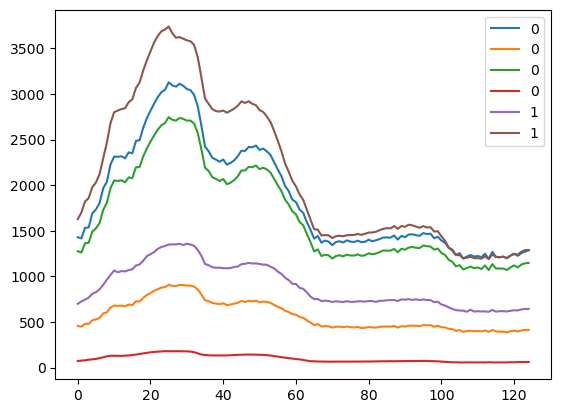

In [63]:
batch_size = 6
data = pd.read_csv('data\stupid_test_data.csv', index_col=0)
aug_data = NIRDataGenerator(df=data, batch_size=batch_size, class_col_name="class")
aug_batch = aug_data[2]
aug_batch_samples = aug_batch[0]
aug_batch_samples_labels = aug_batch[1]
aug_batch_samples_labels

for data in aug_batch_samples:
    plt.plot(data)
    plt.legend(aug_batch_samples_labels)